In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
import torch
from uncertaintylearning.utils import (FixedKernelDensityEstimator, CVKernelDensityEstimator,
                                       create_network, create_optimizer, create_multiplicative_scheduler)
from uncertaintylearning.models import EpistemicPredictor, MCDropout
from torch.utils.data import DataLoader, TensorDataset


In [95]:
def oracle(x, noise=0.1):
    # returns sin(2pi x) + epsilon with epsilon ~ N(0, 0.1)
    with torch.no_grad():
        m = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1]))
        m = m.sample((x.size(0),))
        return (2 * np.pi * x).sin() + noise * m

def generate_data(n=1024, sep=1):
    # generate data from U([0, 1/2] union U([1/2 + sep, 1 + sep]))
    # sep needs to be < 1.5
    with torch.no_grad():
        x = torch.zeros(n // 2, 1).uniform_(0, 0.5)
        x = torch.cat((x, torch.zeros(n // 2, 1).uniform_(1.5, 2)), 0)
        # x = torch.zeros(n, 1).uniform_(0, 2)
        x_test = torch.linspace(-3, 5, 1024).view(-1, 1)
        ood_x = torch.FloatTensor(24, 1).uniform_(0.5, 1.5)
        ood_x = torch.cat((ood_x, torch.FloatTensor(12, 1).uniform_(-2, 0)), 0)
        ood_x = torch.cat((ood_x, torch.FloatTensor(12, 1).uniform_(2, 4)), 0)
        y = oracle(x)
        y2 = oracle(x)
        ood_y = oracle(ood_x)
        y_test_true = oracle(x_test, noise=0)
        return x, y, y2, x_test, y_test_true, ood_x, ood_y

x, y, y2, x_test, y_test, ood_x, ood_y = generate_data()


In [107]:
density_estimator = CVKernelDensityEstimator(use_log_density=False)
features = 'xD'
networks = {'a_predictor': create_network(1, 1, 64, 'tanh', True),
            'e_predictor': create_network(len(features), 1, 128, 'relu', True, 3),
            'f_predictor': create_network(1, 1, 64, 'relu', False)
            }

optimizers = {'a_optimizer': create_optimizer(networks['a_predictor'], 1e-2),
              'e_optimizer': create_optimizer(networks['e_predictor'], 1e-3),
              'f_optimizer': create_optimizer(networks['f_predictor'], 1e-3)
              }

model = EpistemicPredictor(train_X=x,
                           train_Y=y,
                           networks=networks,
                           optimizers=optimizers,
                           density_estimator=density_estimator,
                           train_Y_2=y2,
                           ood_X=ood_x,
                           ood_Y=ood_y,
                           bounds=(-2, 5),
                           features=features)


In [97]:
model.pretrain_density_estimator(x)

In [98]:
density_estimator.score_samples(x_test)

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

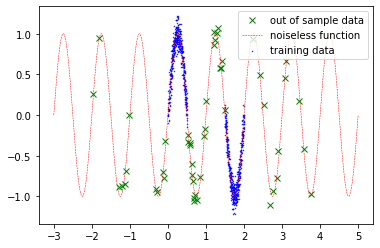

In [24]:
plt.scatter(x, y, color='b', s=.2, label='training data')
plt.plot(ood_x, ood_y, 'gx', label='out of sample data')
plt.plot(x_test, y_test, 'r--', linewidth=.5, label='noiseless function')
try:
    plt.plot(x_test, density_estimator.score_samples(x_test), label='density')
except:
    pass
# plt.plot(x_test, model.distance_estimator.score_samples(x_test), label='distance')

plt.legend()
plt.show()


In [109]:
epochs = 3
losses = {'a': [], 'e': [], 'f': []}

for i in range(epochs):
    new_losses = model.fit()
    for key in 'afe':
        losses[key].extend(new_losses[key])


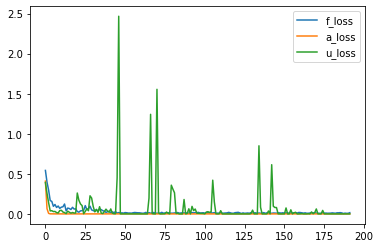

In [110]:
plt.plot(losses['f'], label='f_loss')
plt.plot(losses['a'], label='a_loss')
plt.plot(losses['e'], label='u_loss')
plt.legend()
plt.show()

In [111]:
predictions = networks['f_predictor'](x_test).detach().numpy().ravel()

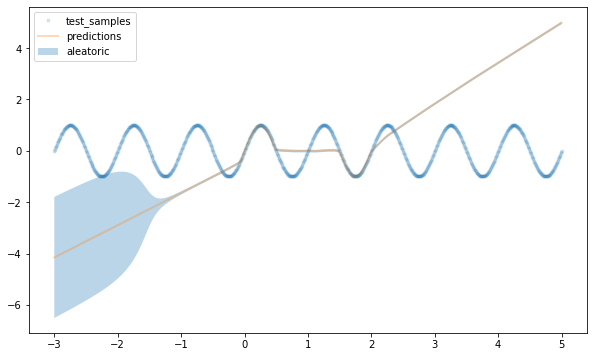

In [112]:
plt.figure(figsize=(10, 6))

aleatoric_u = networks['a_predictor'](x_test).detach().numpy().ravel()
a_low = predictions - np.sqrt(aleatoric_u)
a_high = predictions + np.sqrt(aleatoric_u)

plt.plot(x_test, y_test, '.', label='test_samples', alpha=.15)
plt.plot(x_test, predictions, label='predictions', alpha=.3, lw=2)
plt.fill_between(x_test.numpy().ravel(), a_low, a_high, alpha=.3, label='aleatoric')


epistemic_u = model._epistemic_uncertainty(x_test).detach().numpy().ravel()

e_low = predictions - np.sqrt(epistemic_u)
e_high = predictions + np.sqrt(epistemic_u)

# plt.fill_between(x_test.numpy().ravel(), e_low, e_high, alpha=.3, label='epistemic')

exp_epistemic_uncertainty = (networks['f_predictor'](x_test) - y_test).pow(2).detach().numpy().ravel()
exp_total_uncertainty = exp_epistemic_uncertainty + 0.1 ** 2  # squaring noise to get variance !!

exp_e_low = predictions - np.sqrt(exp_epistemic_uncertainty)
exp_e_high = predictions + np.sqrt(exp_epistemic_uncertainty)

# plt.fill_between(x_test.numpy().ravel(), exp_e_low, exp_e_high, alpha=.15, label='out of sample error')
plt.legend()
plt.show()

total_uncertainty = epistemic_u + aleatoric_u


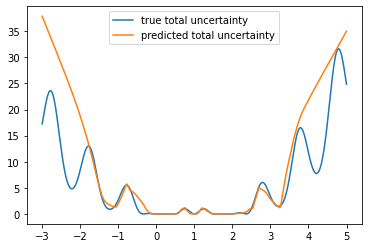

In [113]:
plt.plot(x_test, exp_total_uncertainty, label='true total uncertainty')
plt.plot(x_test, total_uncertainty, label='predicted total uncertainty')
plt.legend()
plt.show()

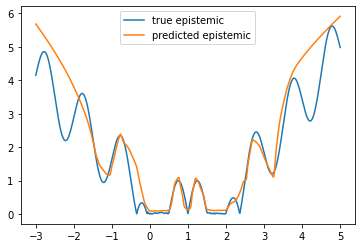

In [114]:
plt.plot(x_test.view(-1).numpy(), np.sqrt(exp_epistemic_uncertainty), label='true epistemic')
plt.plot(x_test.view(-1).numpy(), np.sqrt(epistemic_u), label='predicted epistemic')
# plt.plot(x_test, np.sqrt(epistemic_mcdrop), label='MCDropout epistemic')

plt.legend()
plt.show()

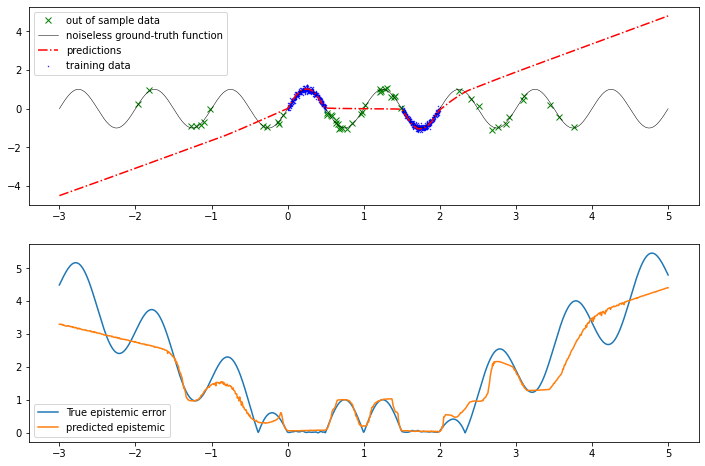

In [87]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].scatter(x, y, color='b', s=.2, label='training data')
axes[0].plot(ood_x, ood_y, 'gx', label='out of sample data')
axes[0].plot(x_test, y_test, 'k-', linewidth=.5, label='noiseless ground-truth function')
axes[0].plot(x_test, predictions, 'r-.', label='predictions')

axes[0].legend()

axes[1].plot(x_test.view(-1).numpy(), np.sqrt(exp_epistemic_uncertainty), label='True epistemic error')
axes[1].plot(x_test.view(-1).numpy(), np.sqrt(epistemic_u), label='predicted epistemic')

axes[1].legend()
plt.savefig('figs/oodgen.pdf')
plt.show()

In [50]:
model.e_predictor.input_layer.in_features

2

In [125]:

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)



# Instantiate a Gaussian Process model

kernel = C(1.0, (1e-3, 1e3)) * RBF(5e-1, (1e-1, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(x.numpy(), y.squeeze().numpy())


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=0.5),
                         n_restarts_optimizer=5)

In [126]:
gp.kernel

1**2 * RBF(length_scale=0.5)

In [130]:
pred, sigma = gp.predict(x_test.numpy(), return_std=True)

/Users/salem/miniconda3/envs/epistemic/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [131]:
sigma

array([31.6227766, 31.6227766, 31.6227766, ..., 31.6227766, 31.6227766,
       31.6227766])

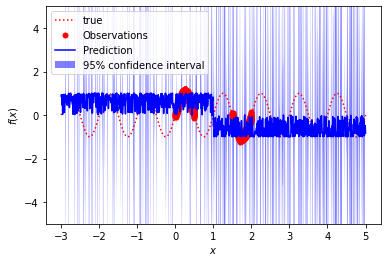

In [129]:
plt.figure()
plt.plot(x_test, y_test, 'r:', label=r'true')
plt.plot(x, y, 'r.', markersize=10, label='Observations')
plt.plot(x_test, pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x_test.numpy(), x_test.numpy()[::-1]]),
         np.concatenate([pred - 1.9600 * sigma,
                        (pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-5, 5)
plt.legend(loc='upper left')


In [76]:
np.concatenate([x_test.numpy(), x_test.numpy()[::-1]])

array([[-3.       ],
       [-2.9921799],
       [-2.9843597],
       ...,
       [-2.9843597],
       [-2.9921799],
       [-3.       ]], dtype=float32)

In [75]:
x_test

tensor([[-3.0000],
        [-2.9922],
        [-2.9844],
        ...,
        [ 4.9844],
        [ 4.9922],
        [ 5.0000]])

In [110]:
x

tensor([[0.3163],
        [0.1553],
        [0.1802],
        ...,
        [1.6447],
        [1.5823],
        [1.6517]])